* CNN Tutorial: https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial 

* VGG-16 - CNN Model: https://www.geeksforgeeks.org/vgg-16-cnn-model/ 

* VGG-16 Tutorial: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c / https://www.kaggle.com/code/loaiabdalslam/vgg16-layers-visualization-tutorial/notebook 

* Report: https://arxiv.org/pdf/1409.1556v6.pdf

**8 STEPS FOR IMPLEMENTING VGG16 IN KEARS**
- Import the libraries for VGG16.
- Create an object for training and testing data.
- Initialize the model.
- Pass the data to the dense layer.
- Compile the model.
- Import libraries to monitor and control training.
- Visualize the training/validation data.
- Test your model. 

Dataset: https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [1]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 68 Apr  6 01:47 kaggle.json
/content


In [2]:
# download datasets files from kaggle
!kaggle datasets download -d andrewmvd/animal-faces

 99% 689M/696M [00:06<00:00, 158MB/s]
100% 696M/696M [00:06<00:00, 108MB/s]


In [3]:
import zipfile 
zip_ref = zipfile.ZipFile('/content/animal-faces.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
#import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns; sns.set(font_scale = 1.5)
import matplotlib.pyplot as plt
import keras
import os 
import cv2
import random
import tensorflow as tf 
import keras.utils as image
from tensorflow import keras
from keras import applications
from keras import layers, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import load_model, save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle  

%matplotlib inline

In [5]:
class_names = ['Dog', 'Cat', 'Wildlife']
class_name_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
print(class_name_label)
IMAGE_SIZE = (224, 224)

{'Dog': 0, 'Cat': 1, 'Wildlife': 2}


The default input size for this model is 224x224.

**VGG Architecture:** 

The input to the network is an image of dimensions (224, 224, 3). The first two layers have 64 channels of a 3*3 filter size and the same padding. Then after a max pool layer of stride (2, 2), two layers have convolution layers of 128 filter size and filter size (3, 3). This is followed by a max-pooling layer of stride (2, 2) which is the same as the previous layer. Then there are 2 convolution layers of filter size (3, 3) and 256 filters. After that, there are 2 sets of 3 convolution layers and a max pool layer. Each has 512 filters of (3, 3) size with the same padding. This image is then passed to the stack of two convolution layers. In these convolution and max-pooling layers, the filters we use are of the size 3*3 instead of 11*11 in AlexNet and 7*7 in ZF-Net. In some of the layers, it also uses 1*1 pixel which is used to manipulate the number of input channels. There is a padding of 1-pixel (same padding) done after each convolution layer to prevent the spatial feature of the image.

***Limitations Of VGG 16:***

It is very slow to train (the original VGG model was trained on Nvidia Titan GPU for 2-3 weeks).
The size of VGG-16 trained imageNet weights is 528 MB. So, it takes quite a lot of disk space and bandwidth which makes it inefficient.
138 million parameters lead to exploding gradients problem.
Further advancements: Resnets are introduced to prevent exploding gradients problem that occurred in VGG-16.

Why binary_crossentropy and categorical_crossentropy give different performances for the same problem?https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances 

In [6]:
#data augmentation, generators, create ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, 
                              rotation_range = 5,  # randomly rotate images in the range 5 degrees
                              zoom_range = 0.1, # Randomly zoom image 10%
                              width_shift_range = 0.1, # randomly shift images horizontally 10%
                              height_shift_range = 0.1, # randomly shift images vertically 10%
                              horizontal_flip = True, # randomly flip images
                              vertical_flip = False) # randomly flip images
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

#prepare iterators
train_generator = train_datagen.flow_from_directory(
    directory = '/content/afhq/train',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224)
    )

val_generator = val_datagen.flow_from_directory(
    directory = '/content/afhq/val', 
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224)
    )

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


The number of batches is equal to number of iterations for one epoch.

In [7]:
# Define the input shape
input_shape = (224, 224, 3)

# Create an input tensor
inputs = Input(shape = input_shape)

# Load the VGG16 model without the top layers
vgg16 = keras.applications.vgg16
model = vgg16.VGG16(weights = 'imagenet', 
                    include_top = False,
                    input_tensor = inputs)

# Add a flatten layer after the convolutional layers
x = Flatten()(model.output)

# Add the top layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(3, activation = 'softmax')(x)

# Create the modified VGG16 model
model = tf.keras.Model(inputs = inputs, outputs = output)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [8]:
#pass optimizer by name: default parameters will be used
#define the optimizer, compile model'
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001) 
#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) 
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [9]:
#to save the model by monitoring a specific parameter of the model
#passing val_acc to ModelCheckpoint
checkpoint = ModelCheckpoint('vgg16_1.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch')

#to stop the training of the model early if there is no increase in the parameter
#passing val_acc to EarlyStopping
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 20, verbose = 1, mode = 'auto')

#fit the model, for better result increase the epochs
history = model.fit_generator(train_generator, steps_per_epoch = 100, epochs = 50, validation_data = val_generator, callbacks = [checkpoint, early])

<ipython-input-9-84387613e271>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch = 100, epochs = 50, validation_data = val_generator, callbacks = [checkpoint, early])


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.8110
Epoch 1: val_accuracy improved from -inf to 0.96267, saving model to vgg16_1.h5
100/100 [==============================] - 113s 811ms/step - loss: 0.4646 - accuracy: 0.8110 - val_loss: 0.1080 - val_accuracy: 0.9627
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9522
Epoch 2: val_accuracy improved from 0.96267 to 0.97067, saving model to vgg16_1.h5
100/100 [==============================] - 74s 740ms/step - loss: 0.1277 - accuracy: 0.9522 - val_loss: 0.0899 - val_accuracy: 0.9707
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.97067 to 0.98467, saving model to vgg16_1.h5
100/100 [==============================] - 74s 736ms/step - loss: 0.0636 - accuracy: 0.9787 - val_loss: 0.0576 - val_accuracy: 0.9847
Epoch 4/50
100/100 [==============================] - ETA: 0s -

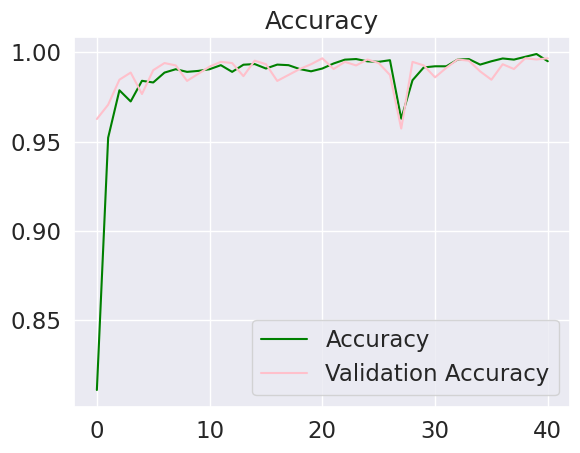

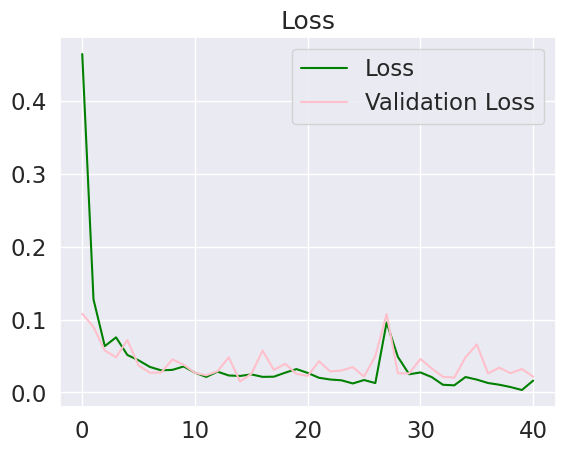

In [10]:
#Test visualization
#Plot the loss and accuracy curves for training and validation 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'green', label = 'Accuracy')
plt.plot(epochs, val_accuracy, 'pink', label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'green', label = 'Loss')
plt.plot(epochs, val_loss, 'pink', label = 'Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

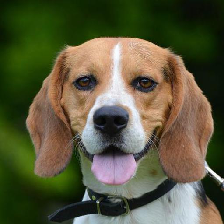

In [18]:
#Loading sample image
#img_path = '/content/afhq/train/cat/flickr_cat_000020.jpg'
#img = Image.open(img_path)
#img = img.convert('RGB').resize((224, 224))

#img_dir = '/content/afhq/train/cat'
img_dir = '/content/afhq/train/dog'
#img_dir = '/content/afhq/train/wild'
img_filename = random.choice(os.listdir(img_dir))
img_path = os.path.join(img_dir, img_filename)

img = load_img(img_path, target_size=(224, 224))
display(img)
#convert to numpy array
#Unsupported image shape: (1, 224, 224, 3) -> The expected shape is (224, 224, 3)
img = img_to_array(img)
img = np.expand_dims(img, axis = 0)

In [19]:
img = preprocess_input(img)
output = model.predict(img)

print(output)

class_labels = {0: 'Cat', 1: 'Dog', 2: 'Wild'}
pred_classes = output.argmax(axis=-1)[0] #classes smaller than 1000

# get the predicted class label
pred_class_label = class_labels[pred_classes]

print('Predicted class:', pred_class_label)

1/1 [==============================] - 0s 21ms/step
[[0. 1. 0.]]
Predicted class: Dog
